In [1]:
import os
import pickle
import time
import sys
sys.path.insert(0, '/home/farnoush/symbolicXAI/')
import numpy as np
from lrp.symbolic_xai import ViTSymbolicXAI
from model.vision_transformer import ModifiedViTForImageClassification
import matplotlib.pylab as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import transformers
import torchvision
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM
import pickle
import itertools
import torch
from torchvision.transforms.functional import crop
from torchvision.ops import box_iou
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/home/farnoush/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/farnoush/venv/lib/python3.10/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


## Extract eyes, mouth, and eyebrows segments

In [2]:
with open('/home/farnoush/eyes_segments.json', 'rb') as f:
    eyes_file = pickle.load(f)

with open('/home/farnoush/eyebrows_segments.json', 'rb') as f:
    eyebrows_file = pickle.load(f)

with open('/home/farnoush/mouth_segments.json', 'rb') as f:
    mouth_file = pickle.load(f)

In [3]:
def filter_boxes(boxes, masks, logits, part='eyes'):
    """
    Filter extracted bounding boxes based on their confidence scores and some other criteria.
    """
    num = 0
    if part == 'eyes':
        num = 2
    elif part == 'mouth':
        num = 1
    elif part == 'eyebrows':
        num = 2

    # If the mask is covering more than half of the image, remove it.
    for i in range(len(logits)):
        score = masks[i].sum() / (224 * 224)
        if score > 0.5:
            logits[i] = 0

    indices = logits.argsort()[::-1]
    values = logits[indices]
    indices = indices[values != 0]
    
    if len(logits) > num:
        indices = indices[:num]

    return indices


def split_image_into_patches(image, patch_size):
    """
    Split an image into patches of a given size.
    """
    # Get the dimensions of the image.
    image_width, image_height = image.size

    # Define the patch size.
    patch_width, patch_height = patch_size

    # Initialize a list to store patch bounding boxes.
    patch_bounding_boxes = []

    # Loop through the image and extract patches.
    for y in range(0, image_height, patch_height):
        for x in range(0, image_width, patch_width):
            # Define the bounding box coordinates.
            left = x
            upper = y
            right = x + patch_width
            lower = y + patch_height

            # Append the bounding box to the list.
            patch_bounding_boxes.append((left, upper, right, lower))

            # Extract the patch.
            patch = image.crop((left, upper, right, lower))

    return patch_bounding_boxes

def find_intersecting_patches(box, patches):
    """
    Check if there is an intersection between a bounding box and a patch.
    """
    # Convert box and patches to tensor
    box_tensor = torch.tensor([box], dtype=torch.float32)
    patches_tensor = torch.tensor(patches, dtype=torch.float32)

    # Calculate IoU (Intersection over Union) between the box and patches
    iou = box_iou(box_tensor, patches_tensor)

    # Find indices where IoU is non-zero (indicating intersection)
    intersecting_indices = torch.nonzero(iou.squeeze() > 0).squeeze().tolist()

    return intersecting_indices

In [4]:
boxes_eyes = []
for dic in tqdm(eyes_file):
    indices = filter_boxes(boxes=dic['boxes_eyes'], masks=dic['mask_eyes'], logits=dic['logits_eyes'], part='eyes')
    if indices is not None:
        boxes_eyes.append(np.expand_dims(dic['boxes_eyes'][indices], axis=0))
    else:
        boxes_eyes.append(dic['boxes_eyes'][indices])

boxes_mouth = []
for dic in tqdm(mouth_file):
    indices = filter_boxes(dic['boxes_mouth'], dic['mask_mouth'], dic['logits_mouth'], 'mouth')
    if indices is not None:
        boxes_mouth.append(np.expand_dims(dic['boxes_mouth'][indices], axis=0))
    else:
        boxes_mouth.append(dic['boxes_mouth'][indices])

boxes_eyebrows = []
for dic in tqdm(eyebrows_file):
    indices = filter_boxes(dic['boxes_eyebrows'], dic['mask_eyebrows'], dic['logits_eyebrows'], 'eyebrows')
    if indices is not None:
       boxes_eyebrows.append(np.expand_dims(dic['boxes_eyebrows'][indices], axis=0)) 
    else:
        boxes_eyebrows.append(dic['boxes_eyebrows'][indices])

100%|██████████████████████████████████████| 280/280 [00:00<00:00, 15100.03it/s]


In [5]:
crop_size = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

size = int((256 / 224) * crop_size)
segmentation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size),
    torchvision.transforms.CenterCrop(crop_size),
])


patch_size = 16
image_patches = []
for dic in tqdm(eyes_file):
    path = dic['image']
    image_pil = Image.open(path).convert("RGB")
    sample = segmentation_transforms(image_pil)
    patches = split_image_into_patches(sample, (16, 16))
    image_patches.append(patches)

100%|████████████████████████████████████████| 280/280 [00:00<00:00, 351.72it/s]


In [6]:
eyes_indices = []
mouth_indices = []
eyebrows_indices = []

for i in tqdm(range(280)):
    eyes = []
    for box in boxes_eyes[i][0]:
        eyes.extend(find_intersecting_patches(box, image_patches[i]))
    eyes_indices.append(eyes)

    eyebrows = []
    for box in boxes_eyebrows[i][0]:
        eyebrows.extend(find_intersecting_patches(box, image_patches[i]))
    eyebrows_indices.append(eyebrows)

    mouth = []
    for box in boxes_mouth[i][0]:
        mouth.append(find_intersecting_patches(box, image_patches[i]))
    mouth_indices.append(mouth)

  0%|                                                   | 0/280 [00:00<?, ?it/s]/tmp/ipykernel_658190/2241369276.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  box_tensor = torch.tensor([box], dtype=torch.float32)
100%|███████████████████████████████████████| 280/280 [00:00<00:00, 1276.11it/s]


After a thorough visual insepction, these images were found to be problematic.

In [7]:
problematic_images = [
    12,
    15,
    16,
    17,
    24,
    253,
    260,
    263,
    279,
    3,
    4,
    5,
    9,
    13,
    252
]

## Use Symbolic XAI framework

In [9]:
crop_size = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

size = int((256 / 224) * crop_size)
size = 224

label_to_id = {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size, interpolation=3),
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

/home/farnoush/venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### Load model

In [10]:
processor = transformers.AutoImageProcessor.from_pretrained("dima806/facial_emotions_image_detection")
model = transformers.AutoModelForImageClassification.from_pretrained("dima806/facial_emotions_image_detection")
model.eval()

model.vit.embeddings.patch_embeddings.requires_grad = False
model.vit.embeddings.patch_embeddings.requires_grad = False

for name, param in model.named_parameters():
    if name.endswith('embed'):
        param.requires_grad = False

pretrained_embeddings = model.vit.embeddings

In [64]:
mode = 1  # There are 2 options {1, 2}

data_rel_dic = {}
ids_dic = {}  # A dictionary that stores the ids of images that are correctly classified and belong to 'sad' or 'happy' classes.
num = 0
total = 0

for i, dic in enumerate(tqdm(eyes_file)):
    path = dic['image']  
    label = label_to_id[dic['label']] 
    image_pil = Image.open(path).convert("RGB")
    sample = transforms(image_pil)

    target = torch.eye(7, dtype=sample.dtype)[0]
    # target[0] = -1

    symb_xai_vit = ViTSymbolicXAI(
        model=model,
        embeddings=pretrained_embeddings,
        sample=sample.unsqueeze(0),
        target=target
    )

    pred = model(sample.unsqueeze(0))['logits'].argmax()

    # Only consider 'happy' and 'sad' classes.
    if label in [0, 6] and i not in problematic_images:
        total += 1
        if label == pred.item():
            ids_dic[num] = i
            num += 1

            if False:
                eyes = list(np.array(eyes_indices[i]).flatten() + 1) + list(np.array(eyebrows_indices[i]).flatten() + 1) 
                mouth = list(np.array(mouth_indices[i]).flatten() + 1) 
                rest = list(set(symb_xai_vit.node_domain) - set(mouth) - set(eyes))
                
                not_mouth = list(set(symb_xai_vit.node_domain) - set(mouth))
                not_eyes = list(set(symb_xai_vit.node_domain) - set(eyes))
                not_rest = list(set(symb_xai_vit.node_domain) - set(rest))
                
                if mode == 1:
                    # Eyes
                    eyes_relevance = symb_xai_vit.symb_or(eyes) + symb_xai_vit.symb_or(not_mouth) - symb_xai_vit.symb_or(eyes + not_mouth)
        
                    # Mouth
                    mouth_relevance = symb_xai_vit.symb_or(not_eyes) + symb_xai_vit.symb_or(mouth) - symb_xai_vit.symb_or(not_eyes + mouth)
        
                    # Eyes and Mouth
                    eyes_and_mouth_relevance = symb_xai_vit.symb_or(eyes) + symb_xai_vit.symb_or(mouth) - symb_xai_vit.symb_or(eyes + mouth)
        
                    # Rest
                    rest_relevance = symb_xai_vit.subgraph_relevance(rest)
    
                elif mode == 2:
                    # Eyes
                    eyes_relevance = symb_xai_vit.subgraph_relevance(eyes)
        
                    # Mouth
                    mouth_relevance = symb_xai_vit.subgraph_relevance(mouth)
        
                    # Eyes and Mouth
                    eyes_and_mouth_relevance = symb_xai_vit.symb_or(eyes) + symb_xai_vit.symb_or(mouth) - symb_xai_vit.symb_or(eyes + mouth)
                    
                    # Rest
                    rest_relevance = symb_xai_vit.symb_or(rest + not_eyes + not_mouth)
        
        
                R_values = [eyes_relevance.item(), mouth_relevance.item(), eyes_and_mouth_relevance, rest_relevance.item()]
    
            data_rel_dic[i] = R_values

100%|█████████████████████████████████████████| 280/280 [15:39<00:00,  3.36s/it]


In [65]:
ids_dic

{0: 0,
 1: 1,
 2: 7,
 3: 8,
 4: 10,
 5: 14,
 6: 18,
 7: 19,
 8: 20,
 9: 21,
 10: 22,
 11: 23,
 12: 25,
 13: 26,
 14: 30,
 15: 31,
 16: 32,
 17: 33,
 18: 34,
 19: 35,
 20: 36,
 21: 38,
 22: 39,
 23: 240,
 24: 241,
 25: 242,
 26: 244,
 27: 245,
 28: 246,
 29: 247,
 30: 248,
 31: 249,
 32: 250,
 33: 251,
 34: 254,
 35: 255,
 36: 256,
 37: 257,
 38: 258,
 39: 259,
 40: 261,
 41: 262,
 42: 264,
 43: 265,
 44: 266,
 45: 267,
 46: 268,
 47: 269,
 48: 270,
 49: 272,
 50: 273,
 51: 274,
 52: 275,
 53: 277}

In [13]:
with open('/home/farnoush/data_rel_sad_unnormalized_q1_generalized_gamma.pkl', 'wb') as f:
    pickle.dump(data_rel_dic, f)

Open saved relevance files.

In [58]:
# Open saved relavance values.
data_len = 53
X = np.zeros((data_len, 4, 2)) 
y = np.zeros((data_len))

lbs = ['sad', 'happy']

for i in range(2):
    with open('/home/farnoush/data_rel_{}_unnormalized_q1_generalized_gamma.pkl'.format(lbs[i]), 'rb') as f:
        data_rel_dic = pickle.load(f)
        print(len(data_rel_dic))

    for idx, (key, data) in enumerate(data_rel_dic.items()):
        label = label_to_id[eyebrows_file[key]['label']]
        for  j in range(4):
            X[idx, j, i] = data[j]
        y[idx] = label

53
53


In [38]:
X.shape

(53, 4, 2)

## Visualization

In [48]:
X = X / X.sum(axis=1, keepdims=True)

/tmp/ipykernel_658190/2745667137.py:1: RuntimeWarning: invalid value encountered in divide
  X = X / X.sum(axis=1, keepdims=True)


In [33]:
data_len = 53
if False:
    X = np.zeros((data_len, 3)) 
    y = np.zeros((data_len))
    
    for idx, (key, data) in enumerate(data_rel_dic.items()):
        label = label_to_id[eyebrows_file[key]['label']]
        for  j in range(3):
            X[idx, j] = data[j]
        y[idx] = label

X_hat = X[y == 0]
y_hat = y[y == 0]

In [33]:
all_data_eyes = []
for x in X_hat[:, 0]:
    all_data_eyes.append(x)

all_data_mouth = []
for x in X_hat[:, 1]:
    all_data_mouth.append(x)

all_data_em = []
for x in X_hat[:, 2]:
    all_data_em.append(x)

if False:
    all_data_rest = []
    for x in X_hat[:, 3]:
        all_data_rest.append(x)

# all_data = [np.array(all_data_eyes), np.array(all_data_mouth), np.array(all_data_em), np.array(all_data_rest)]
all_data = [np.array(all_data_eyes), np.array(all_data_mouth), np.array(all_data_em)]

In [49]:
np.random.seed(0)

# ----- Eyes ------
# Sad
ys_neg_eyes = X[y == 0][:, 0, 1] - X[y == 0][:, 0, 0]
xs_neg_eyes = np.random.normal(1, 0.1, ys_neg_eyes.shape[0])

# Happy
ys_pos_eyes = X[y == 6][:, 0, 1] - X[y == 6][:, 0, 0]
xs_pos_eyes = np.random.normal(2, 0.1, ys_pos_eyes.shape[0])

# ----- Mouth ------
# Sad
ys_neg_mouth = X[y == 0][:, 1, 1] - X[y == 0][:, 1, 0]
xs_neg_mouth = np.random.normal(1, 0.1, ys_neg_mouth.shape[0])

# Happy
ys_pos_mouth = X[y == 6][:, 1, 1] - X[y == 6][:, 1, 0]
xs_pos_mouth = np.random.normal(2, 0.1, ys_pos_mouth.shape[0])

# ----- Eyes & Mouth ------
# Sad
ys_neg_em = X[y == 0][:, 2, 1] - X[y == 0][:, 2, 0]
xs_neg_em = np.random.normal(1, 0.1, ys_neg_em.shape[0])

# Happy
ys_pos_em = X[y == 6][:, 2, 1] - X[y == 6][:, 2, 0]
xs_pos_em = np.random.normal(2, 0.1, ys_pos_em.shape[0])


# ----- Rest ------
# Sad
ys_neg_rest = X[y == 0][:, 3, 1] - X[y == 0][:, 3, 0]
xs_neg_rest = np.random.normal(1, 0.1, ys_neg_em.shape[0])

# Happy
ys_pos_rest = X[y == 6][:, 3, 1] - X[y == 6][:, 3, 0]
xs_pos_rest = np.random.normal(2, 0.1, ys_pos_em.shape[0])

[-0.09650916  0.2069003 ]


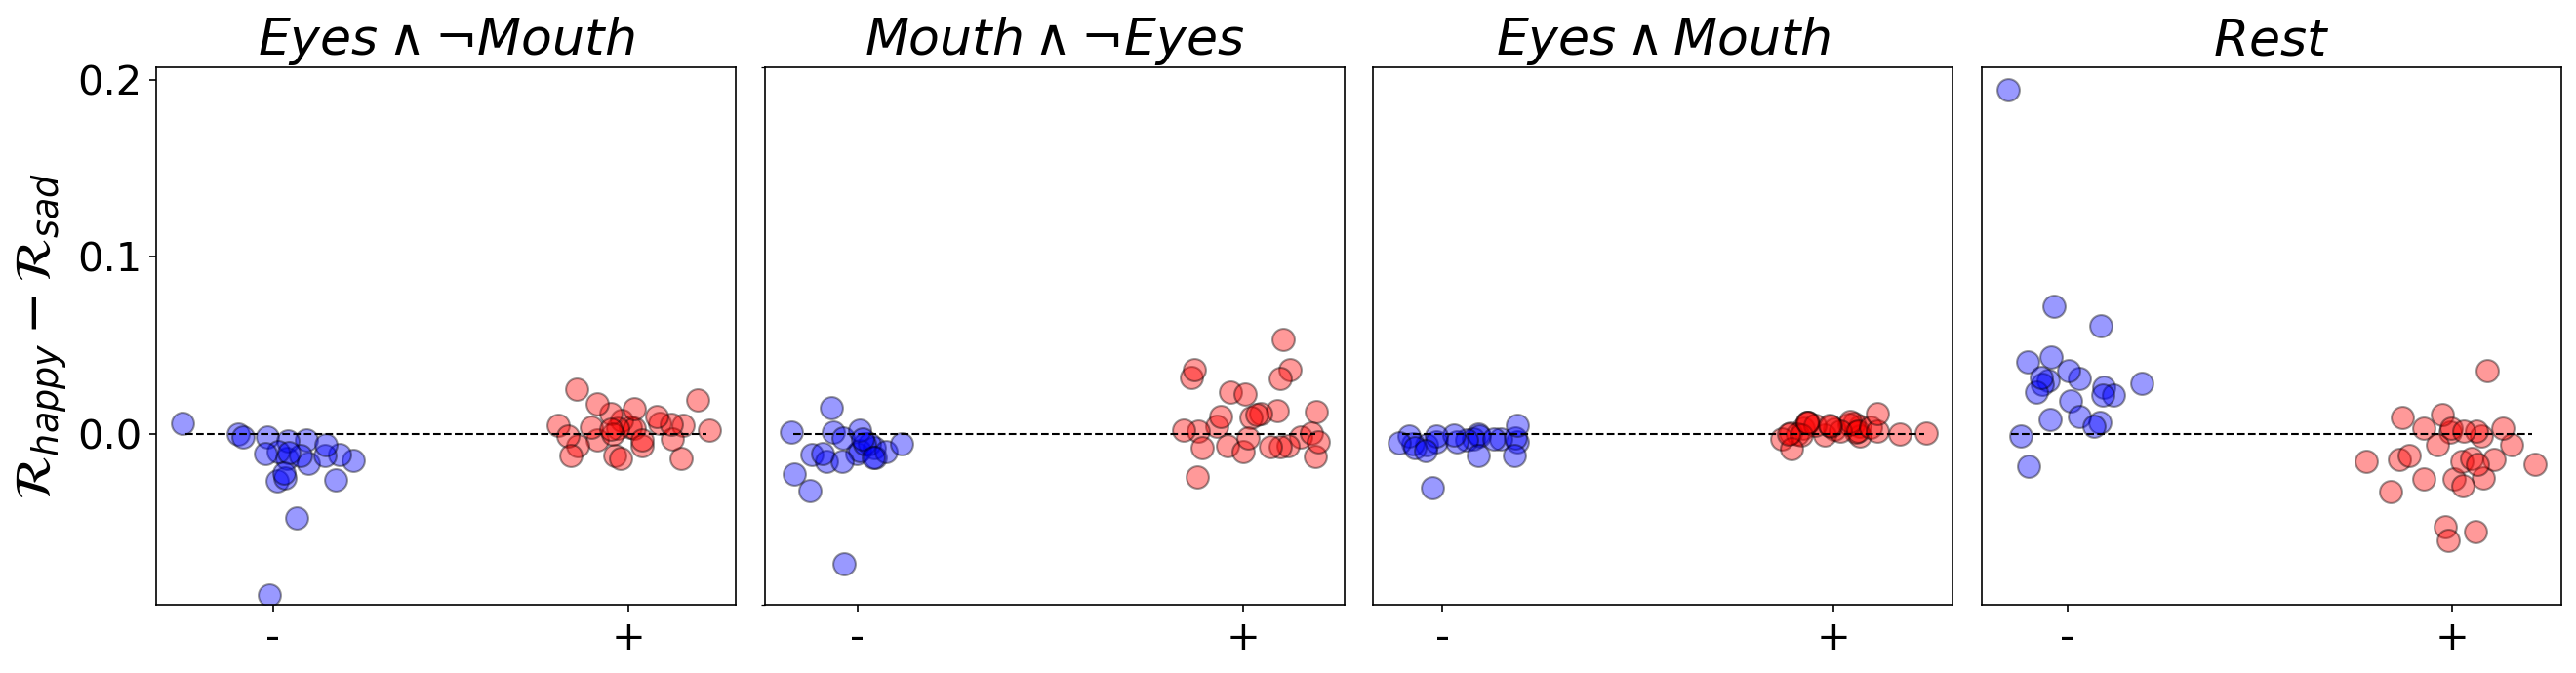

In [50]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 4, dpi=150, figsize=(18, 5))
axs[0].scatter(xs_neg_eyes, ys_neg_eyes, alpha=.4, edgecolors='black', color='blue', s=120)
axs[0].scatter(xs_pos_eyes, ys_pos_eyes, alpha=.4, edgecolors='black', color='red', s=120)
# axs[0].set_title('$Eyes \\wedge \\neg{\\overline{Eyes}}$', size=25)
axs[0].set_title('$Eyes \\wedge \\neg{Mouth}$', size=25)
axs[0].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[0].set_ylabel("$\\mathcal{R}_{happy} - \\mathcal{R}_{sad}$", size=25)
axs[0].set_xticks([1, 2], ['-', '+'], size=20)
# axs[0].set_yscale('symlog')

axs[1].scatter(xs_neg_mouth, ys_neg_mouth, alpha=.4, edgecolors='black', color='blue', s=120)
axs[1].scatter(xs_pos_mouth, ys_pos_mouth, alpha=.4, edgecolors='black', color='red', s=120)
# axs[1].set_title('$Mouth \\wedge \\neg{\\overline{Mouth}}$', size=25)
axs[1].set_title('$Mouth \\wedge \\neg{Eyes}$', size=25)
axs[1].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[1].set_yscale('symlog')
axs[1].set_xticks([1, 2], ['-', '+'], size=20)
axs[1].set_yticks([])

axs[2].scatter(xs_neg_em, ys_neg_em, alpha=.4, edgecolors='black', color='blue', s=120)
axs[2].scatter(xs_pos_em, ys_pos_em, alpha=.4, edgecolors='black', color='red', s=120)
axs[2].set_title('$Eyes \\wedge Mouth$', size=25)
axs[2].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)                                                
# axs[2].set_yscale('symlog')
axs[2].set_xticks([1, 2], ['-', '+'], size=20)
axs[2].set_yticks([])

axs[3].scatter(xs_neg_rest, ys_neg_rest, alpha=.4, edgecolors='black', color='blue', s=120)
axs[3].scatter(xs_pos_rest, ys_pos_rest, alpha=.4, edgecolors='black', color='red', s=120)
axs[3].set_title('$Rest$', size=25)
axs[3].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)                                                
# axs[2].set_yscale('symlog')
axs[3].set_xticks([1, 2], ['-', '+'], size=20)
axs[3].set_yticks([])

# lim = np.array(list(axs[1].get_ylim())) + np.array(list(axs[0].get_ylim())) + np.array(list(axs[2].get_ylim()))

lim = None
min_lim = axs[0].get_ylim()[0]
max_lim = axs[0].get_ylim()[1]
for i in range(1, 4):
    l = axs[i].get_ylim()
    if l[0] < min_lim:
        min_lim = l[0]
    if l[1] > max_lim:
        max_lim = l[1]

lim = np.array([min_lim, max_lim])
print(lim)
    
axs[0].set_ylim(lim)
axs[1].set_ylim(lim)
axs[2].set_ylim(lim) 
axs[3].set_ylim(lim)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("/home/farnoush/symbolicXAI/figures/symbxai_vision_quant.png", facecolor=(1,1,1,0), bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), dpi=200)

# plot box plot
labels = ['Eyes', 'Mouth', 'Eyes & Mouth']
bplot = axs.boxplot(
    all_data,
    labels=labels,
    patch_artist=True)
axs.set_title('Logit: "Sad (-1)", Images: "Happy"')

# adding horizontal grid lines
axs.yaxis.grid(True)
axs.set_ylabel('Score')
axs.set_xlabel('Query')

colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.ylim(-150, 100)

plt.show()

fig.savefig("/home/farnoush/symbolicXAI/figures/boxplot_sad_happy_2.png", facecolor=(1,1,1,0), bbox_inches='tight')

## Qualitative Results

/home/farnoush/symbolicXAI/dataset/images/validation/happy/30825.jpg
(16, 16, 3)


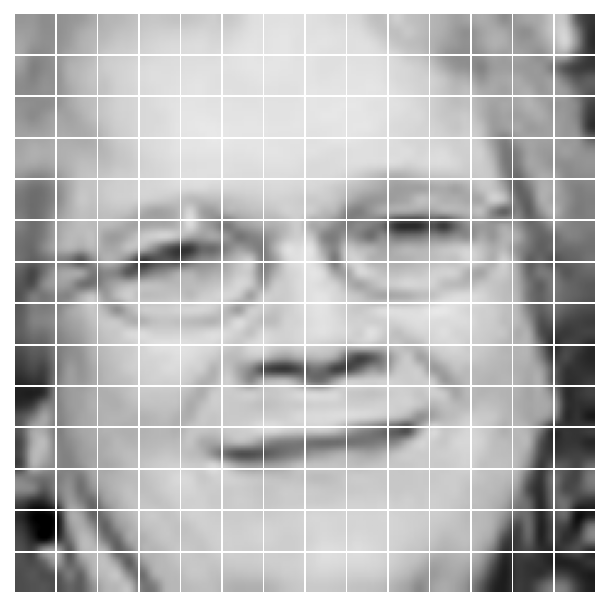

In [18]:
from patchify import patchify

transforms1 = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(size=size, interpolation=3),
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.ToTensor(),
])

sample_id = 275
path = eyes_file[sample_id]['image']
print(eyes_file[sample_id]['image'])
sample1 = transforms1(Image.open(path).convert("RGB"))
patches = patchify(sample1.permute(1, 2, 0).numpy(), (16, 16, 3), step=16).squeeze(2)
print(patches[0, 0].shape)

fig, axs = plt.subplots(14, 14, figsize=(5, 5), dpi=150)

for i in range(14):
    for j in range(14):
        axs[i, j].imshow(patches[i, j])
        axs[i, j].axis('off')

plt.subplots_adjust(wspace=0.001, hspace=0.05)
plt.show()

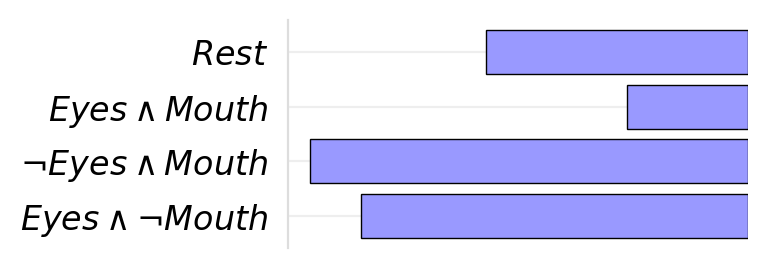

In [75]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'hatch.linewidth': 0.5})
cmap_neg = matplotlib.cm.get_cmap('Blues')
cmap_pos = matplotlib.cm.get_cmap('Reds')

red_color = (1,0.6,0.6)
blue_color = (.6,.6,1)

R_values = X[52, :, 0]
sample_id = 277

width=0.7
alpha = 1
labels = ['$Eyes \\wedge \\neg{Mouth}$', '$\\neg{Eyes} \wedge Mouth$', '$Eyes \\wedge Mouth$', '$Rest$']
# labels = ['$Eyes \\wedge \\neg{\\overline{Eyes}}$', '$Mouth \\wedge \\neg{\\overline{Mouth}}$', '$Eyes \\wedge Mouth$', '$Rest$']
fig, ax = plt.subplots(1, figsize=(4, 1.5), dpi=200)
for i, value in enumerate(R_values):
    if i == 0:
        label = 'Eyes'
    elif i == 1:
        label = 'Mouth'
    elif i == 2:
        label = 'Eyes & Mouth'
    else:
        label = 'Rest'
            
    if value < 0:
        if label:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=blue_color, linewidth=0.5)
    else:
        if label:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5, label=label)
        else:
            bars = ax.barh(i, value, alpha=alpha, edgecolor='black',
                          color=red_color, linewidth=0.5)


ax.set_yticks(np.arange(len(R_values)), labels, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_facecolor("white")

if False:
    legend = ax.legend(title='Context', title_fontsize=12, fontsize=12, loc="upper center",
                       bbox_to_anchor=(-.1, .9))
    title = legend.get_title()
    title.set_weight('bold')

fig.show()
plt.tight_layout()
fig.savefig("/home/farnoush/lang-segment-anything/symb_results/sample_{}_neg_logit.png".format(sample_id), facecolor=(1,1,1,0), bbox_inches='tight')

### First-Order LRP Result

In [12]:
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image, scale_cam_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
import cv2

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model
        # self.model.eval()

    def forward(self, x):
        return self.model(x).logits

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
model_w = HuggingfaceToTensorModelWrapper(model)

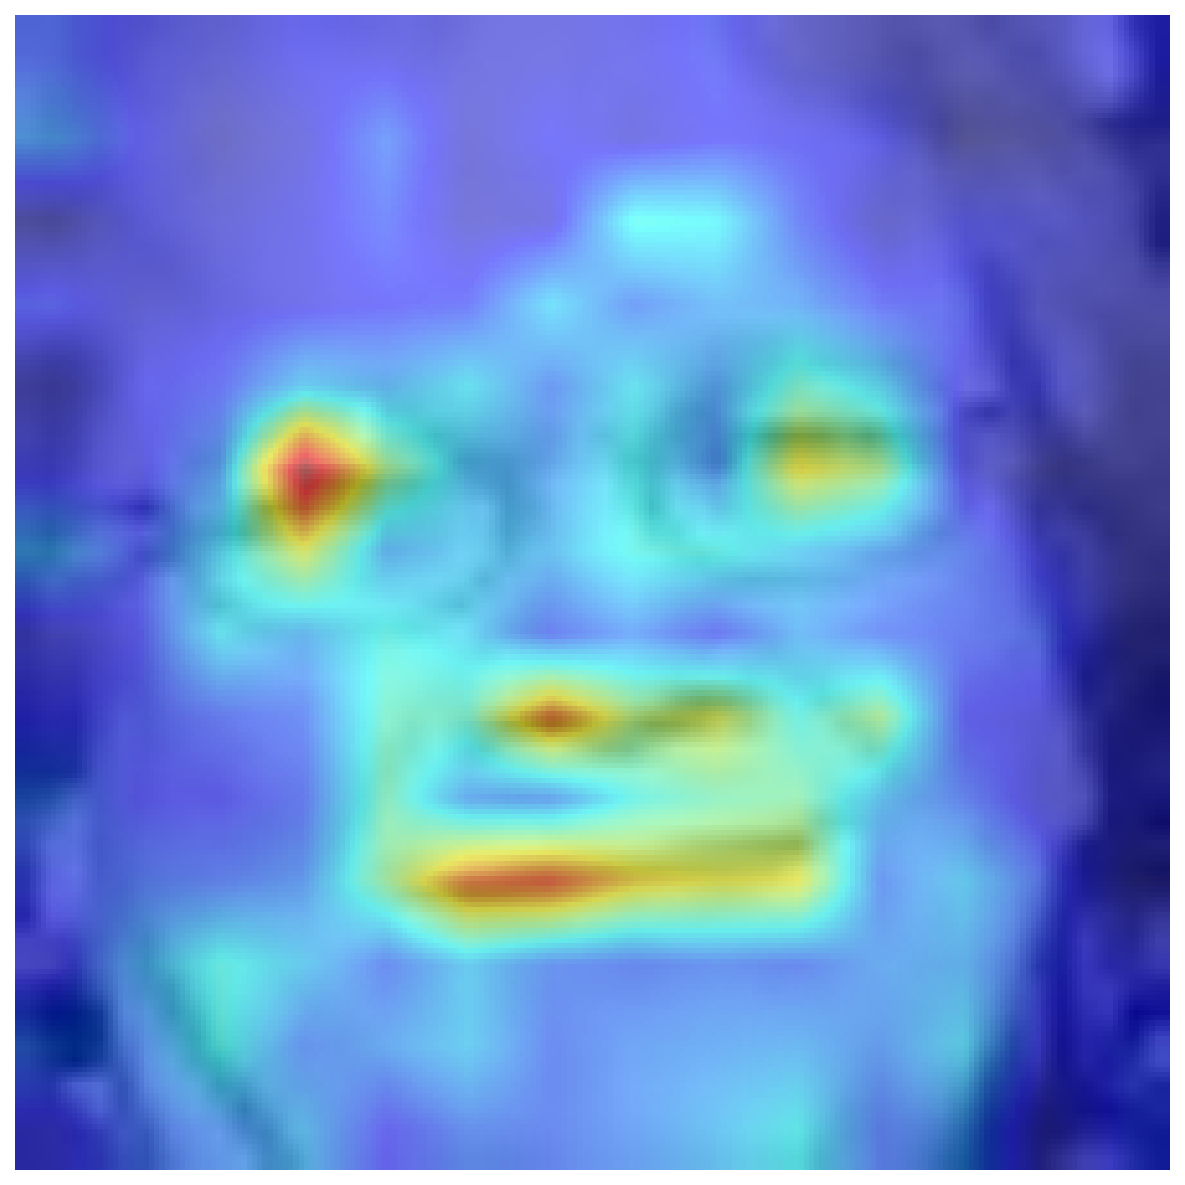

In [34]:
sample_id = 275
sample = transforms(Image.open(eyes_file[sample_id]['image']).convert("RGB"))
label = 6
target = torch.eye(7, dtype=sample.dtype)[label]

symb_xai_vit = ViTSymbolicXAI(
        model=model,
        embeddings=pretrained_embeddings,
        sample=sample.unsqueeze(0),
        target=target
    )

R = symb_xai_vit.node_relevance(mode='node@input').detach().numpy()[1:]

normalized_R = ((R / np.linalg.norm(R)) * 255).clip(0, 255).astype(np.uint8)
scores = scale_cam_image(normalized_R.reshape(1, 14, 14), (224, 224))

rgb_img = np.float32(Image.open(eyes_file[sample_id]['image']).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=150)
h_map  = show_cam_on_image(rgb_img, scores[0], use_rgb=True)
axs.imshow(h_map)
plt.axis('off')
plt.show()

fig.savefig("/home/farnoush/lang-segment-anything/lrp_heatmaps/sample_{}.png".format(sample_id), facecolor=(1,1,1,0), bbox_inches='tight')

In [10]:
(R > 0).sum()

164

## Clustering

In [32]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import preprocessing


def compute_best_mapping(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    return np.transpose(np.asarray(linear_sum_assignment(w.max() - w))), w
    
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    mapping, w = compute_best_mapping(y_true, y_pred)
    return np.array([w[i, j] for i, j in mapping]).sum() * 1.0 / y_pred.size, mapping, w

# Clustering results for each query $q_k \in \mathbb{R}^2$ where $k = 1, 2, 3$.

I only consider the signs of the scores in this case. I used the second query set to produce the following results.


Eyes + Eyebrows --> 0.7058

Mouth --> 0.6078

Eyes & Mouth --> 0.6470

In [33]:
km = True
X_eyes = (X[:, 0, :] > 0).astype(float)

scaler = preprocessing.StandardScaler().fit(X_eyes)
X_scaled = scaler.transform(X_eyes)

if km:
    k_means = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
    y_hat = k_means.fit_predict(X_scaled, y)
else:
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=1000).fit(X_scaled)
    y_hat = clustering.fit_predict(X_scaled, y)

acc = cluster_acc(y, y_hat)[0]
print("Accuracy when using just eyes: {}".format(acc))

Accuracy when using just eyes: 0.5471698113207547


In [34]:
km = True
X_mouth = (X[:, 1, :] > 0).astype(float)

scaler = preprocessing.StandardScaler().fit(X_mouth)
X_scaled = scaler.transform(X_mouth)

if km:
    k_means = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
    y_hat = k_means.fit_predict(X_scaled, y)
else:
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=1000).fit(X_scaled)
    y_hat = clustering.fit_predict(X_scaled, y)

acc = cluster_acc(y, y_hat)[0]
print("Accuracy when using just mouth: {}".format(acc))

Accuracy when using just mouth: 0.660377358490566


In [35]:
km = True
X_em = (X[:, 2, :] > 0).astype(float)

scaler = preprocessing.StandardScaler().fit(X_em)
X_scaled = scaler.transform(X_em)

if km:
    k_means = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
    y_hat = k_means.fit_predict(X_scaled, y)
else:
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=1000).fit(X_scaled)
    y_hat = clustering.fit_predict(X_scaled, y)

acc = cluster_acc(y, y_hat)[0]
print("Accuracy when using just eyes and mouth: {}".format(acc))

Accuracy when using just eyes and mouth: 0.6792452830188679


### Clustering results for each relevance vector  $ r \in \mathbb{R}^{3 \times 2}$ (no dimensionality reduction)

Here, I have only considered the signs of the relevance scores and no dimensionality reduction is performed. 

In [ ]:
X_hat = (X.reshape(data_len, 3*2) > 0).astype(float)
scaler = preprocessing.StandardScaler().fit(X_hat)
X_scaled = scaler.transform(X_hat)

k_means = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
gmm = GaussianMixture(n_components=2, covariance_type='full', max_iter=5000, init_params='k-means++',
                  n_init=100, random_state=0).fit(X_hat)
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=1000).fit(X_scaled)

y_hat_kmeans = k_means.fit_predict(X_scaled, y)
y_hat_clustering = clustering.fit_predict(X_scaled, y)
y_hat_gmm = gmm.fit_predict(X_scaled, y)

acc_kmeans = cluster_acc(y, y_hat_kmeans)[0]
acc_clustering = cluster_acc(y, y_hat_clustering)[0]
acc_gmm = cluster_acc(y, y_hat_gmm)[0]

print("Accuracy achieved by K-means, when using just eyes and mouth: {}".format(acc_kmeans))
print("Accuracy achieved by Spectral Clustering, when using just eyes and mouth: {}".format(acc_clustering))
print("Accuracy achieved by GMM, when using just eyes and mouth: {}".format(acc_gmm))

### Dimensionality reduction using T-SNE 

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib


X_bar = (X.reshape(data_len, 3*2) > 0).astype(float)
tsne = TSNE(n_components=2, perplexity=3, n_iter=5000, random_state=0).fit_transform(X_bar)

### Clustering results for each relevance vector  $ r \in \mathbb{R}^{3 \times 2}$ (after dimensionality reduction)

Perform clustering after dimensionality reduction.

In [51]:
tx = tsne[:, 0]
ty = tsne[:, 1]

X_hat = np.concatenate([tx.reshape(data_len, 1), ty.reshape(data_len, 1)], axis=1)

scaler = preprocessing.StandardScaler().fit(X_hat)
X_scaled = scaler.transform(X_hat)

k_means = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
gmm = GaussianMixture(n_components=2, covariance_type='full', max_iter=5000, init_params='k-means++',
                  n_init=100, random_state=0).fit(X_hat)
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=1000).fit(X_scaled)

y_hat_kmeans = k_means.fit_predict(X_scaled, y)
y_hat_clustering = clustering.fit_predict(X_scaled, y)
y_hat_gmm = gmm.fit_predict(X_scaled, y)

acc_kmeans = cluster_acc(y, y_hat_kmeans)[0]
acc_clustering = cluster_acc(y, y_hat_clustering)[0]
acc_gmm = cluster_acc(y, y_hat_gmm)[0]

print("Accuracy achieved by K-means, when using just eyes and mouth: {}".format(acc_kmeans))
print("Accuracy achieved by Spectral Clustering, when using just eyes and mouth: {}".format(acc_clustering))
print("Accuracy achieved by GMM, when using just eyes and mouth: {}".format(acc_gmm))

Accuracy achieved by K-means, when using just eyes and mouth: 0.5098039215686274
Accuracy achieved by Spectral Clustering, when using just eyes and mouth: 0.5098039215686274
Accuracy achieved by GMM, when using just eyes and mouth: 0.5686274509803921


Perform dimensionality reduction and plot GMM solution on transformed data.

In [37]:
import seaborn as sns

colors = sns.color_palette('tab10', n_colors=20)
colors_per_class = {}

for i, cls in enumerate([0, 6]):
    colors_per_class[cls] = colors[i]

In [38]:
def plot_gmm_solution(X, mu, sigma):
    n_gaussians = mu.shape[0]
    
    # Plotting data points.
    # for every class, we'll add a scatter plot separately
    for label in colors_per_class.keys():
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(y) if l == label]
     
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
     
        # convert the class color to matplotlib format
        color = np.array([colors_per_class[label]])
     
        # add a scatter plot with the corresponding color and label
        plt.scatter(current_tx, current_ty, c=color, label=label, alpha=0.7)
    
    # Plot ellipses and cluster centers
    for i in range(n_gaussians):
        plt.scatter(mu[i, 0], mu[i, 1], marker='X', color='r', s=100)
        vals, vecs = np.linalg.eigh(sigma[i])
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        vecs = vecs / np.linalg.norm(vecs)
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        theta = 180 * theta / np.pi
        width, height = 2 * np.sqrt(vals)
        
        elipse = matplotlib.patches.Ellipse(xy=[mu[i, 0], mu[i, 1]], width=width, height=height, angle=180+theta,
              edgecolor='g', lw=4, facecolor='none')
        plt.gcf().gca().add_artist(elipse)

    plt.axis('off')
    plt.show()

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type='full', max_iter=5000, init_params='k-means++',
                      n_init=100, random_state=0).fit(X_hat)
mu = gmm.means_
sigma = gmm.covariances_
plot_gmm_solution(X_hat, mu, sigma)